In [22]:
import numpy as np
from scipy.sparse import csr_matrix, find
from scipy.spatial import cKDTree
from tqdm import tqdm_notebook as tqdm

from datasets.graph import draw_sample
import torch

model_fname = '/home/sameasy2006/hgcal_ldrd-gravnet2_wip_trainer_args/output_HGC_pion8nn/checkpoints/model_checkpoint_EdgeNetWithCategories_264403_5b5c05404f_sameasy2006.best.pth.tar'




In [38]:
from models.EdgeNetWithCategories import EdgeNetWithCategories
mdl = EdgeNetWithCategories(input_dim=5, hidden_dim=64, output_dim=4, n_iters=6)
mdl.load_state_dict(torch.load(model_fname, map_location=torch.device('cpu'))['model'])
mdl.eval()

EdgeNetWithCategories(
  (inputnet): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): Tanh()
  )
  (edgenetwork): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=4, bias=True)
    (5): LogSoftmax()
  )
  (nodenetwork0): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=101, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=101, out_features=64, bias=True)
    (3): ELU(alpha=1.0)
  ))
  (nodenetwork1): EdgeConv(nn=Sequential(
    (0): Linear(in_features=138, out_features=101, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=101, out_features=64, bias=True)
    (3): ELU(alpha=1.0

In [42]:
test_fname = '/home/sameasy2006/npz_hgcal_k8/pion_hgctup_0to1000/processed/data_0.pt'
data = torch.load(test_fname)
#datas = torch.load('/home/sameasy2006/npz/photon_hfntup_0to1000/processed/data_175.pt')
#pred_edges = mdl(datas).detach()
#pred_edges_np = pred_edges.numpy()
#print(np.unique(np.argmax(pred_edges_np,axis=-1), return_counts=True))
#print(torch.unique(data.y, return_counts=True))
#print(torch.unique(pred_edges, return_counts=True))
#print (data.y)
#print (pred_edges)
#print (data.x.detach().numpy().shape)

In [43]:
X = data.x.detach().numpy()
X.shape



(22633, 5)

In [44]:
pred_edges = mdl(data).detach()
pred_edges_np = pred_edges.numpy()
print(pred_edges_np.shape)

(189866, 4)


In [45]:
index = data.edge_index.numpy().T
Ro = index[:,0]
Ri = index[:,1]
y = data.y.numpy()

out = np.argmax(pred_edges_np,axis=-1)

#out =pred_edges_np

In [71]:
print (np.unique(y))
print (np.unique(out))

[0 1 2]
[0 1]


In [68]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import tqdm

def draw_sample(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
    out_mask = (out > 0)
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
    print('out value:',out)
    print('good_outs:',good_outs)
#    X[:,2]=X[:,2]*150.0
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]  
    
    print(feats_o.shape)
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
    cmap = plt.get_cmap(cmap)
    
#    print(X[:,0])
#    print(X[:,1])
    #print(X[:,2]*150.0)
#    print(X[:,4])
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    e_max = np.max(X[:,4])
#    e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_normed = 100*X[:,4]
    ax0.scatter(X[:,0], X[:,2], s=(e_normed), c='r',alpha=0.2)
    ax1.scatter(X[:,1], X[:,2], s=(e_normed), c='r',alpha=0.2)
    
    
    
       
    lines0 = []
    lines1 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm.tqdm(range(good_outs.shape[0])):
            
            lines0.append([(feats_o[j,0], feats_o[j,2]),(feats_i[j,0], feats_i[j,2])])
            lines1.append([(feats_o[j,1], feats_o[j,2]),(feats_i[j,1], feats_i[j,2])])
            colors.append(color_map[good_outs[j]])
#            colors.append(color_map[3])
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([feats_o[j,0], feats_i[j,0]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            ax1.plot([feats_o[j,1], feats_i[j,1]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    ax1.add_collection(lc1)
    
    # Adjust axes
    ax0.set_xlabel('$x$ [cm]')
    ax1.set_xlabel('$y$ [cm]')
    ax0.set_ylabel('$layer$ [arb]')
    ax1.set_ylabel('$layer$ [arb]')
    plt.tight_layout()
    return fig;
    

100%|██████████| 14902/14902 [00:00<00:00, 373523.28it/s]

out value: [0 0 2 ... 0 0 0]
good_outs: [2 2 2 ... 1 1 1]
(14902, 5)


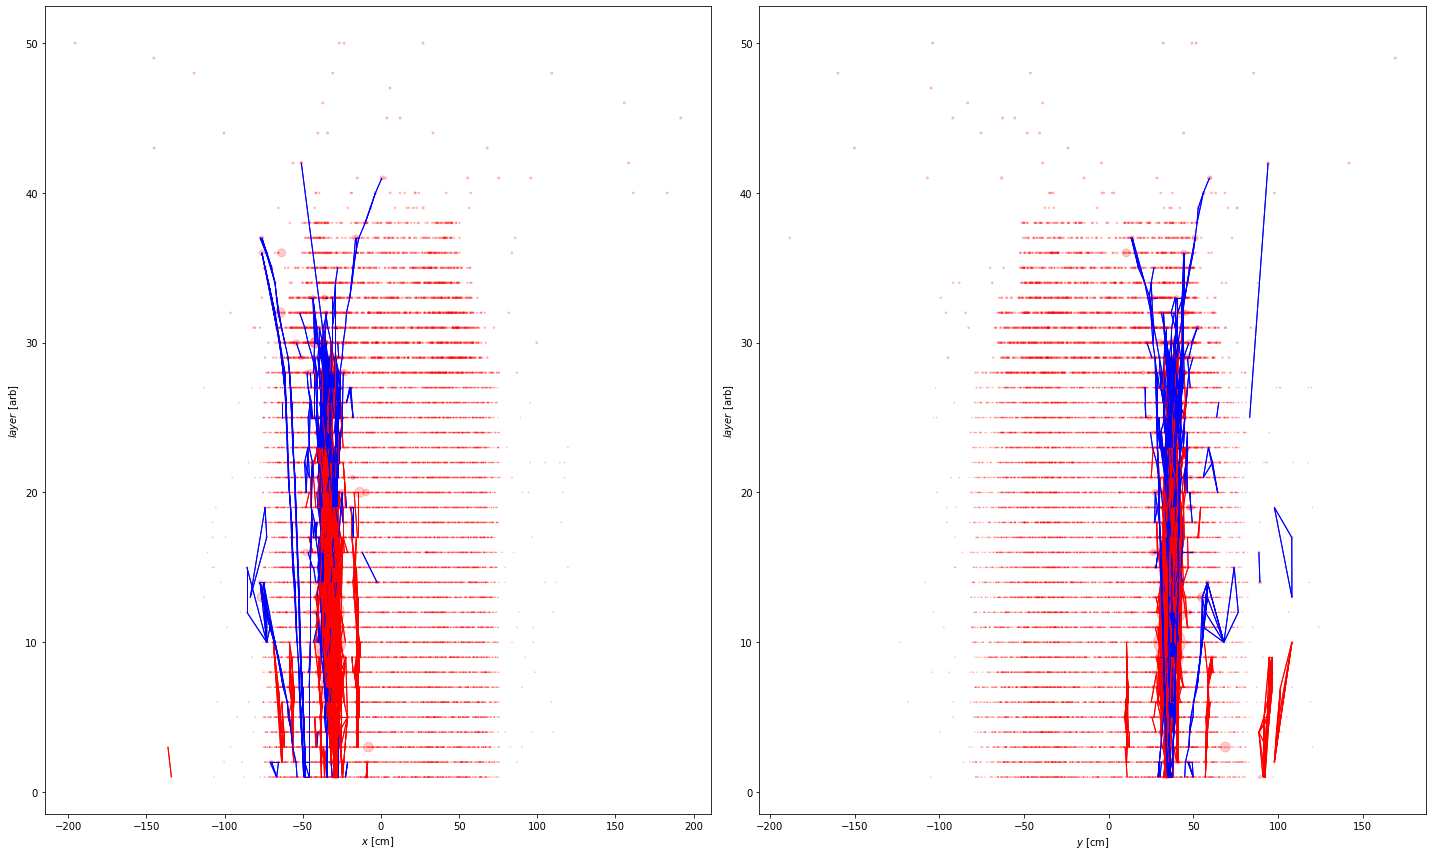

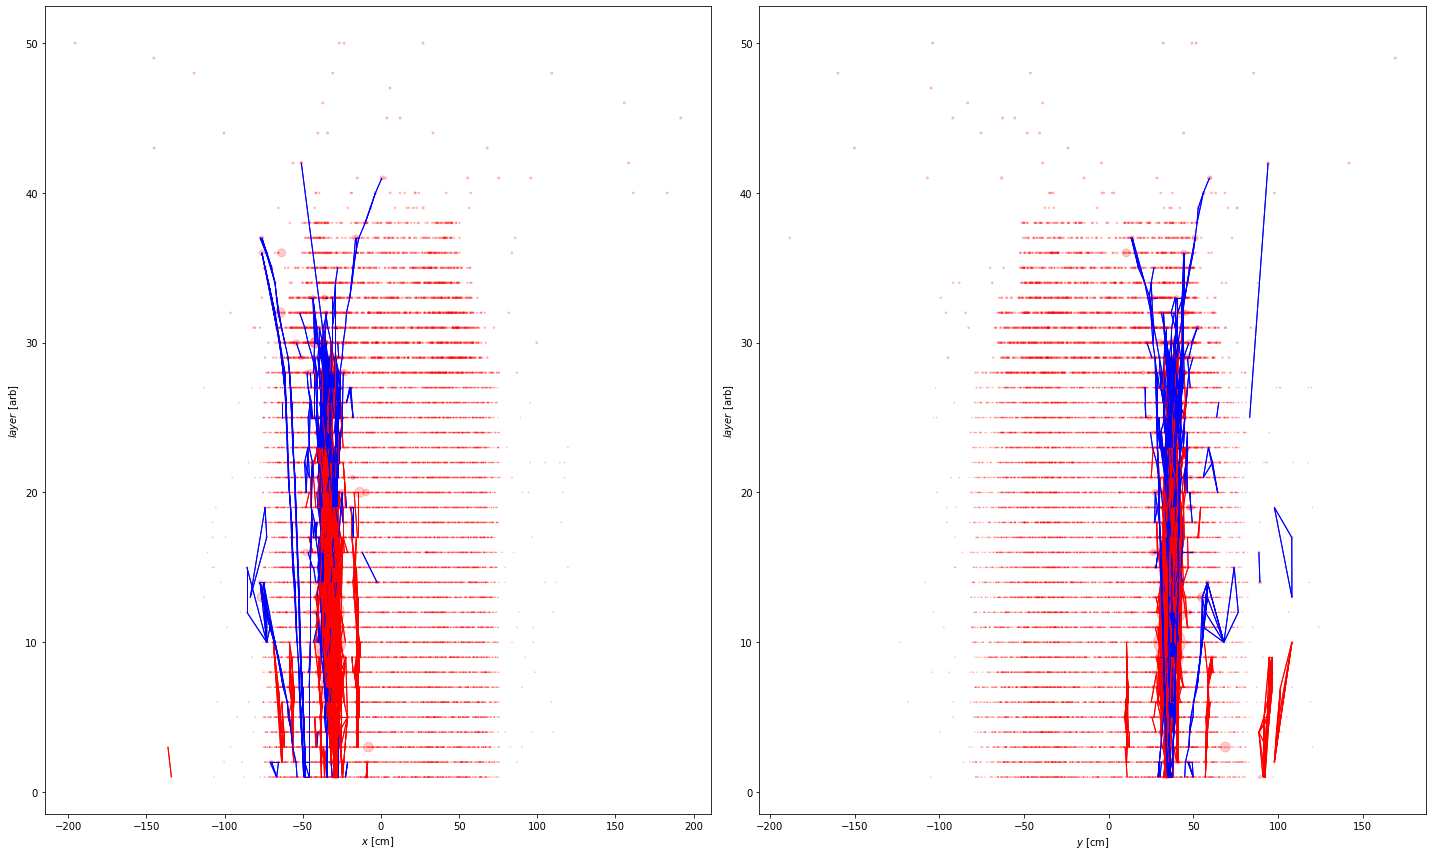

In [69]:
draw_sample(X, Ri, Ro, y, y)

100%|██████████| 21378/21378 [00:00<00:00, 364160.69it/s]

out value: [1 1 1 ... 0 0 0]
good_outs: [1 1 1 ... 1 1 1]
(21378, 5)


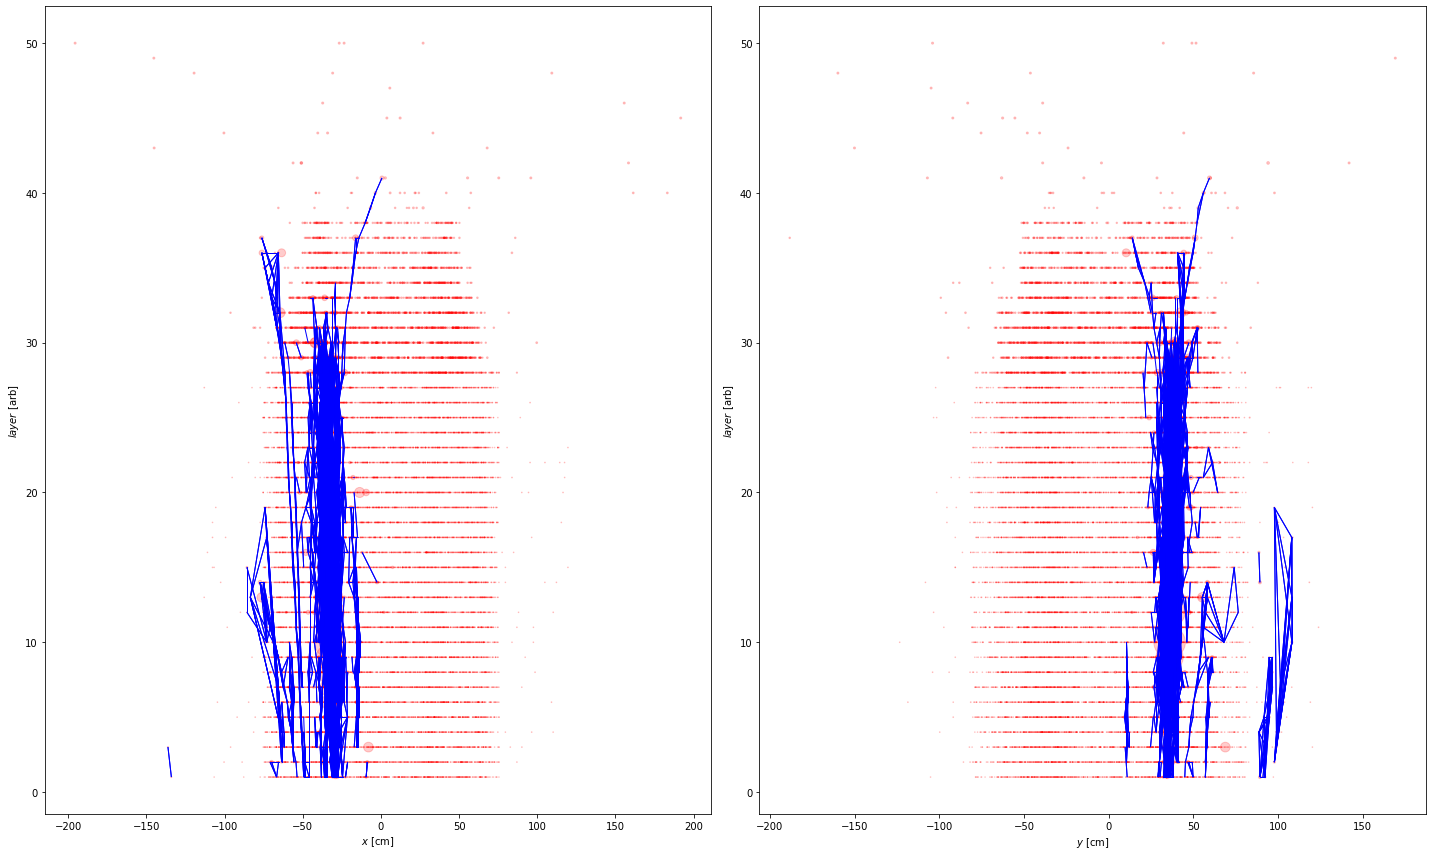

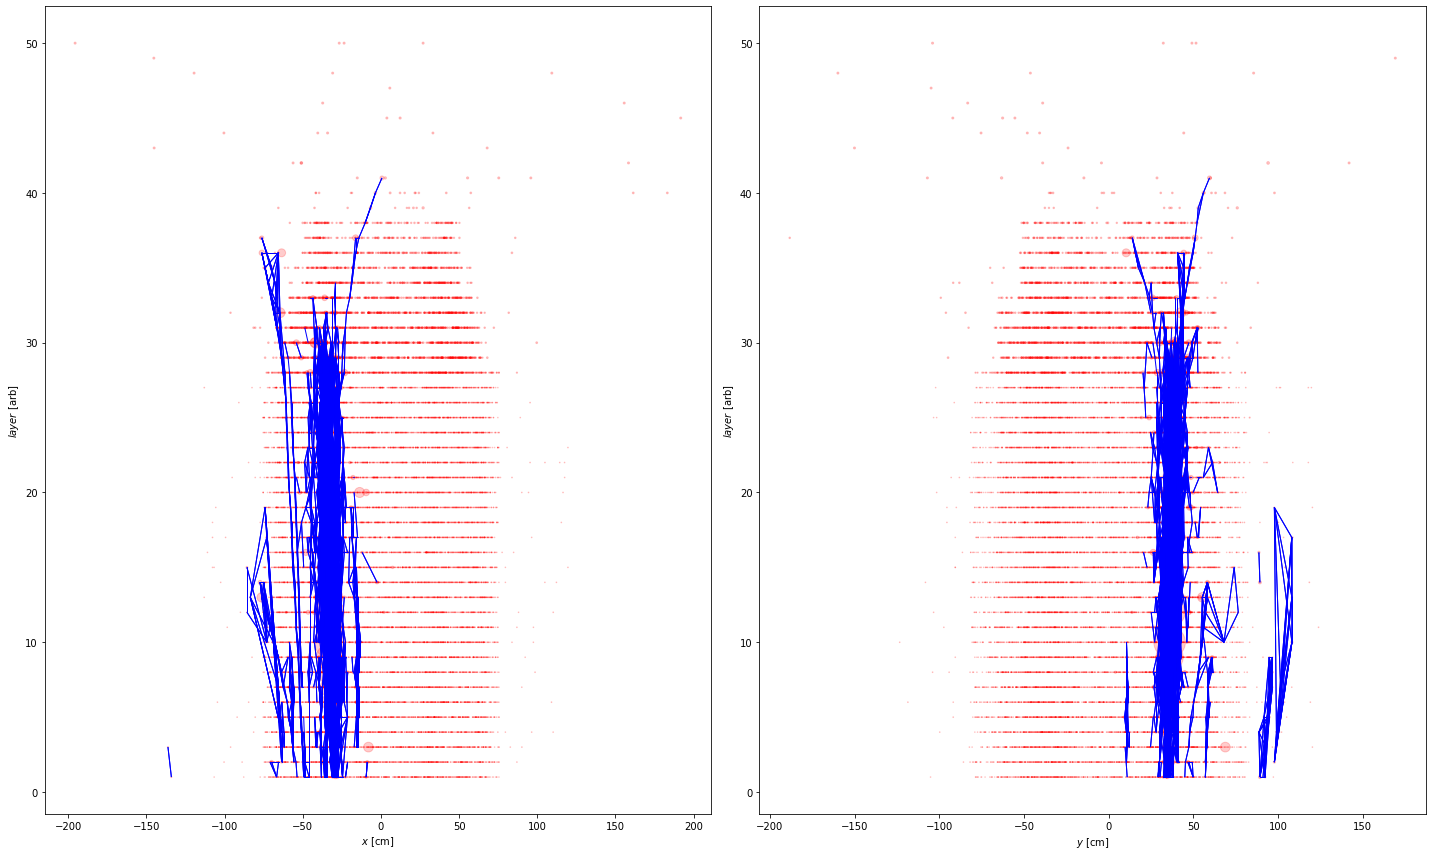

In [70]:
draw_sample(X, Ri, Ro, y, out)

In [23]:
def draw_sample(X, Ri, Ro, y, out,
                cmap='bwr_r', 
                skip_false_edges=True,
                alpha_labels=False, 
                sim_list=None): 
    
    #let's draw only the non-noise edges
#    out_mask = (out >0.5) & (y > 0.5) ### only the correctly predicted signal edges
#    out_mask = (out >0.5) & (y < 0.5) ### only the incorrectly predicted signal edges
#    out_mask =  (y > 0.5) & (out <0.5)  ### signal incorrectly predicted as background
    out_mask =  (y < 0.5) & (out >0.5)  ### background incorrectly predicted as signal
    Ri = Ri[out_mask]
    Ro = Ro[out_mask]
    good_outs = out[out_mask]
    
#    print('out value:',out)
#    print('good_outs:',good_outs)
#    X[:,2]=X[:,2]*150.0
    # Select the i/o node features for each segment    
    feats_o = X[Ro]
    feats_i = X[Ri]  
    
    print(feats_o.shape)
    # Prepare the figure
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(20,12))
    cmap = plt.get_cmap(cmap)
    
#    print(X[:,0])
#    print(X[:,1])
    #print(X[:,2]*150.0)
#    print(X[:,4])
    #if sim_list is None:    
        # Draw the hits (layer, x, y)
    #    ax0.scatter(X[:,0], X[:,2], c='k')
    #    ax1.scatter(X[:,1], X[:,2], c='k')
    #else:        
    
    e_max = np.max(X[:,4])
#    e_normed = np.tanh(X[:,4]/e_max)#1. / (1. + np.exp(-X[:,4]/e_max))
    e_normed = 100*X[:,4]
    ax0.scatter(X[:,0], X[:,2], s=(e_normed), c='r',alpha=0.2)
    ax1.scatter(X[:,1], X[:,2], s=(e_normed), c='r',alpha=0.2)
    
    
    
       
    lines0 = []
    lines1 = []
    colors = []
    # Draw the segments    
    if out is not None:
        #t = tqdm.tqdm()
        color_map = {0: (1,1,1,1),
                     1: (0,0,1,1),
                     2: (1,0,0,1),
                     3: (0,1,0,1)}
        
        for j in tqdm.tqdm(range(good_outs.shape[0])):
            
            lines0.append([(feats_o[j,0], feats_o[j,2]),(feats_i[j,0], feats_i[j,2])])
            lines1.append([(feats_o[j,1], feats_o[j,2]),(feats_i[j,1], feats_i[j,2])])
#            colors.append(color_map[good_outs[j]])
            colors.append(color_map[1])
            #_ = ax0.plot([feats_o[j,0], feats_i[j,0]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            #_ = ax1.plot([feats_o[j,1], feats_i[j,1]],
            #             [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
    else:
        t = tqdm.tqdm(range(y.shape[0]))
        for j in t:
            if y[j]:
                seg_args = dict(c='b', alpha=0.4)
            elif not skip_false_edges:
                seg_args = dict(c='black', alpha=0.4)
            else: continue
                
            ax0.plot([feats_o[j,0], feats_i[j,0]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
            ax1.plot([feats_o[j,1], feats_i[j,1]],
                     [feats_o[j,2], feats_i[j,2]], '-', **seg_args)
        
    col_arr = np.array(colors)
    lc0 = mc.LineCollection(lines0, colors=col_arr, linewidths=1)
    lc1 = mc.LineCollection(lines1, colors=col_arr, linewidths=1)
    
    ax0.add_collection(lc0)
    ax1.add_collection(lc1)
    
    # Adjust axes
    ax0.set_xlabel('$x$ [cm]')
    ax1.set_xlabel('$y$ [cm]')
    ax0.set_ylabel('$layer$ [arb]')
    ax1.set_ylabel('$layer$ [arb]')
    plt.tight_layout()
    return fig;
    

100%|██████████| 556/556 [00:00<00:00, 378208.40it/s]

(556, 5)


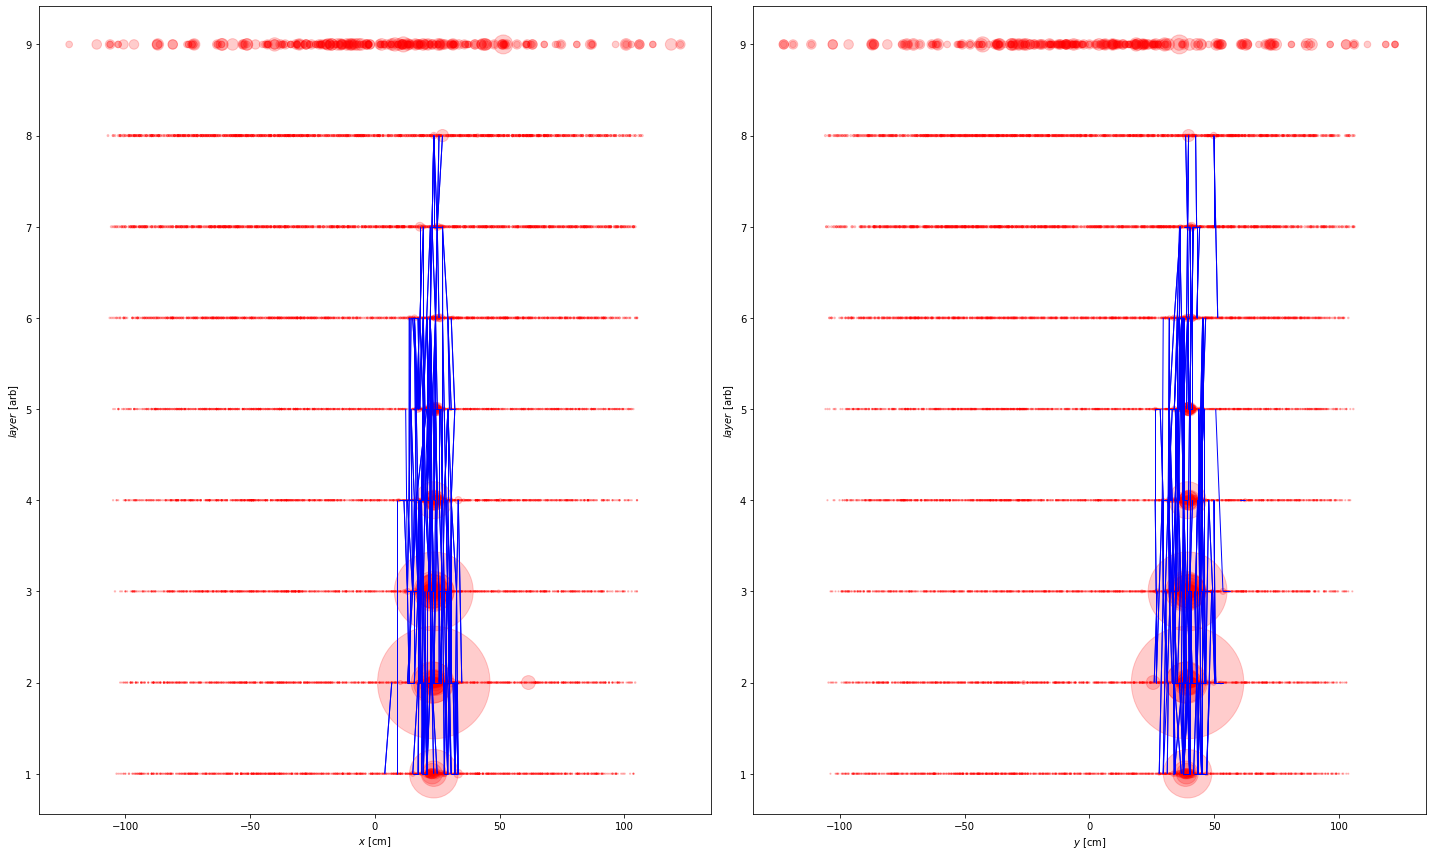

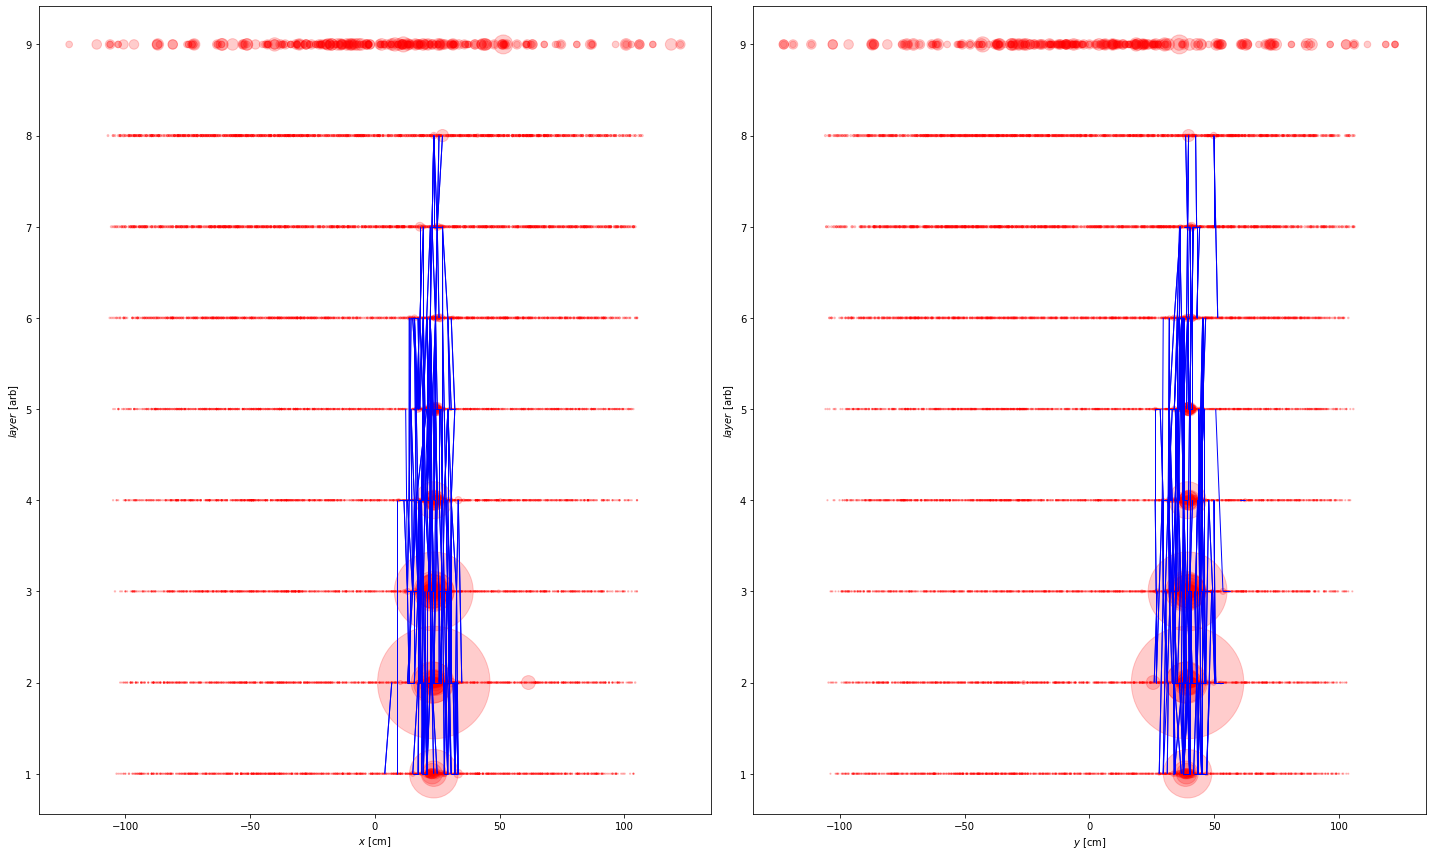

In [24]:
draw_sample(X, Ri, Ro, y, out)

In [12]:
datas = torch.load(test_fname)

In [13]:
datas

Data(edge_index=[2, 65512], x=[10665, 5], y=[65512])

In [14]:
datas.x

tensor([[-4.0897e+01,  1.2084e+00,  1.0000e+00, -1.0000e+00,  1.7270e-02],
        [-4.0897e+01,  2.0140e+00,  1.0000e+00, -1.0000e+00,  1.7270e-02],
        [-4.0200e+01, -1.6112e+00,  1.0000e+00, -1.0000e+00,  1.7270e-02],
        ...,
        [ 1.1134e+01, -9.3425e+00,  9.0000e+00,  0.0000e+00,  8.8299e-01],
        [ 1.3658e+01, -4.9711e+00,  9.0000e+00,  0.0000e+00, -2.6100e-02],
        [ 1.4534e+01,  2.5413e-06,  9.0000e+00,  0.0000e+00,  4.2845e-01]])

In [15]:
X = datas.x.detach().numpy()

In [16]:
X.shape

(10665, 5)